# On trouve ici la construction et l'exploration du premier modele XGBoost

# Objectif Principal
**Simuler TOUS les matchs d'une saison AVANT son commencement**, en utilisant uniquement les données historiques des saisons précédentes.

### Pourquoi cette approche spécifique ?

####  Pourquoi ne pas utiliser la forme récente (ex: 5 derniers matchs) ?
1. **Non représentatif en début de saison** : Les 5 derniers matchs de la saison précédente ne reflètent pas la forme actuelle
2. **Impossible pour simulation complète** : Pour le X-ième match (X>1) de la nouvelle saison, on n'a pas encore les X-1 matchs précédents
3. **Problème d'autocorrélation** : Utiliser les données de la même saison créerait des fuites temporelles

####  Avantages de notre approche :
- **Simulations "zero-shot"** : Prédire toute une saison sans données intra-saison
- **Compatibilité Monte Carlo** : Permet des simulations de classement réalistes
- **Robustesse temporelle** : Ne dépend pas de la forme momentanée

#### Vision long terme :
- **Phase 1** : Ce modèle XGBoost (simulations début de saison)
- **Phase 2** : Implémentation des simulations Monte Carlo pour classement final  
- **Phase 3** : Exploration réseaux récurrents pour modèles intra-saison

#  Optimisation du Modèle de Prédiction Football
## Test des hyperparamètres XGBoost avec visualisations


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from collections import Counter
import psycopg2
from dotenv import load_dotenv
import os

sns.set_palette("husl")

# CHARGEMENT DES DONNÉES ET NETTOYAGE

In [53]:

load_dotenv()

def get_connection():
    return psycopg2.connect(
        user=os.getenv("user"),
        password=os.getenv("password"), 
        host=os.getenv("host"),
        port=os.getenv("port"),
        dbname=os.getenv("dbname")
    )

conn = get_connection()
df = pd.read_sql("SELECT * FROM training_modele_season", conn)
conn.close()


# Nettoyage
colonnes_a_supprimer = ['match_id', 'date_match', 'created_at', 'updated_at']
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df.columns]
df_clean = df.drop(columns=colonnes_existantes)

X = df_clean.drop(columns=['result'])
y = df_clean['result']

# Encoder et split chronologique
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split 2-4 vs 5-6 
train_mask = df['season_id'].isin([2, 3, 4])
test_mask = df['season_id'].isin([5, 6])

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y_encoded[train_mask]
y_test = y_encoded[test_mask]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

C:\Users\User\AppData\Local\Temp\ipykernel_2900\2877871528.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM training_modele_season", conn)


Train: (1140, 21), Test: (760, 21)


# TEST DIFFÉRENTS LEARNING RATES

In [54]:
print("=== TEST DES LEARNING RATES ===")
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2]
results_lr = []

for lr in learning_rates:
    print(f"Testing learning_rate: {lr}")
    
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "merror",
        "learning_rate": lr,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }
    
    # Gestion déséquilibre
    class_counts = Counter(y_train)
    total = sum(class_counts.values())
    weights = {cls: total/count for cls, count in class_counts.items()}
    sample_weights = [weights[label] for label in y_train]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    bst = xgb.train(
        params, 
        dtrain, 
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dtest, 'eval')],
        early_stopping_rounds=20,
        verbose_eval=False
    )
    
    y_pred = bst.predict(dtest).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results_lr.append({
        'learning_rate': lr,
        'accuracy': accuracy,
        'model': bst
    })


=== TEST DES LEARNING RATES ===
Testing learning_rate: 0.01
Testing learning_rate: 0.05
Testing learning_rate: 0.1
Testing learning_rate: 0.15
Testing learning_rate: 0.2


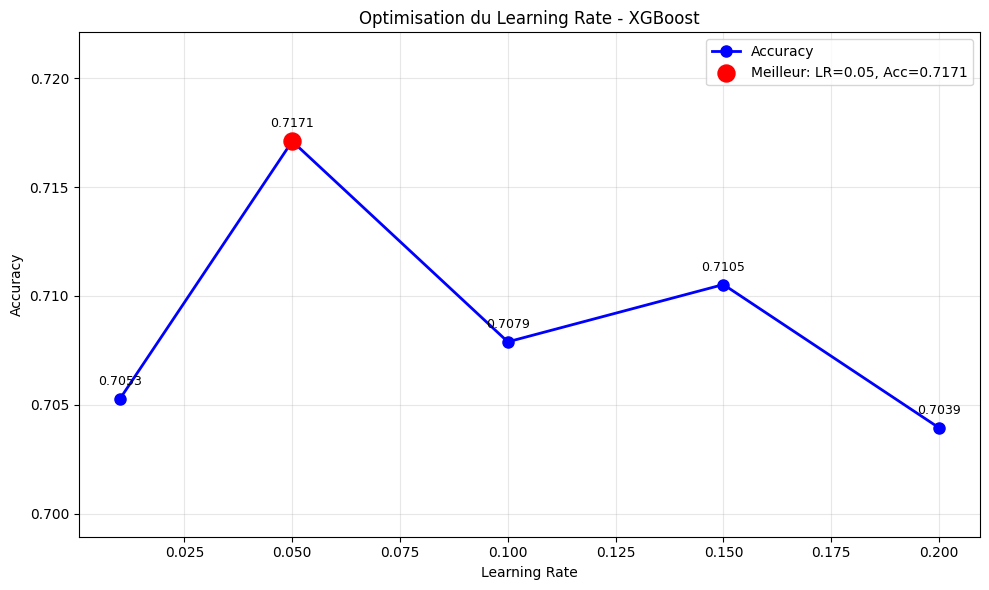

In [55]:
# Visualisation learning rates
plt.figure(figsize=(10, 6))

# Récupérer les données
lrs = [r['learning_rate'] for r in results_lr]
accuracies = [r['accuracy'] for r in results_lr]

# Courbe principale
plt.plot(lrs, accuracies, 'o-', linewidth=2, markersize=8, color='blue', label='Accuracy')

# Trouver le meilleur
best_idx = np.argmax(accuracies)
best_lr = lrs[best_idx]
best_acc = accuracies[best_idx]

# Point le meilleur en évidence
plt.scatter(best_lr, best_acc, color='red', s=150, zorder=5, 
           label=f'Meilleur: LR={best_lr}, Acc={best_acc:.4f}')

# Annotations pour tous les points
for i, (lr, acc) in enumerate(zip(lrs, accuracies)):
    plt.annotate(f'{acc:.4f}', (lr, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=9)

plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Optimisation du Learning Rate - XGBoost')
plt.grid(True, alpha=0.3)
plt.legend()

# Ajuster les limites pour mieux voir
plt.ylim(min(accuracies) - 0.005, max(accuracies) + 0.005)

plt.tight_layout()
plt.show()

# Test des profondeurs

In [56]:

max_depths = [3, 4, 5, 6, 7, 8, 9]
results_depth = []

for depth in max_depths:
    print(f"Testing max_depth: {depth}")
    
    params = {
        "objective": "multi:softprob", 
        "num_class": 3,
        "eval_metric": "merror",
        "learning_rate": best_lr,  # Utilise le meilleur LR trouvé
        "max_depth": depth,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }
    
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    bst = xgb.train(
        params, 
        dtrain, 
        num_boost_round=200,
        evals=[(dtrain, 'train'), (dtest, 'eval')],
        early_stopping_rounds=20,
        verbose_eval=False
    )
    
    y_pred = bst.predict(dtest).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results_depth.append({
        'max_depth': depth,
        'accuracy': accuracy,
        'model': bst
    })


Testing max_depth: 3
Testing max_depth: 4
Testing max_depth: 5
Testing max_depth: 6
Testing max_depth: 7
Testing max_depth: 8
Testing max_depth: 9


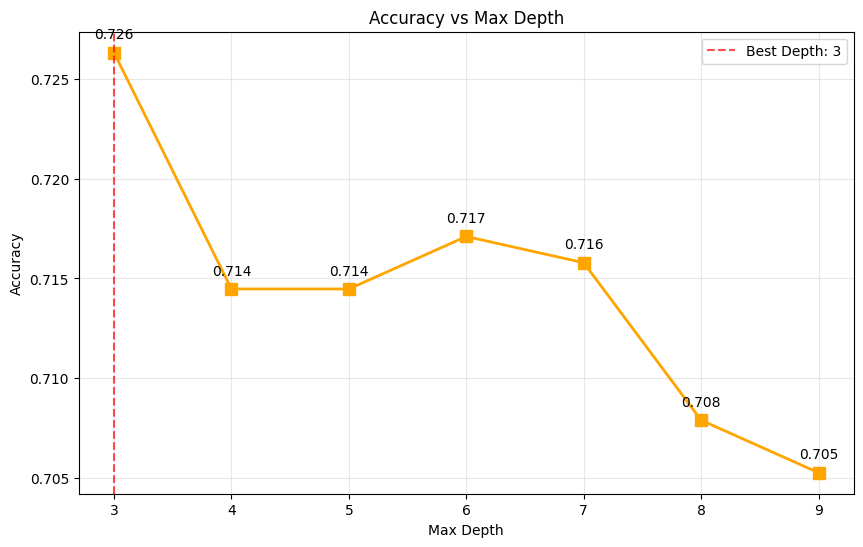

In [57]:
# Visualisation max_depth
plt.figure(figsize=(10, 6))
depths = [r['max_depth'] for r in results_depth]
accuracies = [r['accuracy'] for r in results_depth]

plt.plot(depths, accuracies, 's-', linewidth=2, markersize=8, color='orange')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.grid(True, alpha=0.3)

best_depth_idx = np.argmax(accuracies)
best_depth = depths[best_depth_idx]
plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7, label=f'Best Depth: {best_depth}')
plt.legend()

for i, (depth, acc) in enumerate(zip(depths, accuracies)):
    plt.annotate(f'{acc:.3f}', (depth, acc), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

# RECHERCHE MULTIDIMENSIONNEL


In [58]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

results_grid = []

# Combinaisons (version simplifiée)
for lr in param_grid['learning_rate']:
    for depth in param_grid['max_depth']:
        print(f"Testing LR: {lr}, Depth: {depth}")
        
        params = {
            "objective": "multi:softprob",
            "num_class": 3, 
            "eval_metric": "merror",
            "learning_rate": lr,
            "max_depth": depth,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "seed": 42
        }
        
        dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=200,
            early_stopping_rounds=20,
            evals=[(dtest, 'eval')],
            verbose_eval=False
        )
        
        y_pred = bst.predict(dtest).argmax(axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        
        results_grid.append({
            'learning_rate': lr,
            'max_depth': depth, 
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'accuracy': accuracy,
            'model': bst
        })

Testing LR: 0.01, Depth: 3
Testing LR: 0.01, Depth: 4
Testing LR: 0.01, Depth: 5
Testing LR: 0.05, Depth: 3
Testing LR: 0.05, Depth: 4
Testing LR: 0.05, Depth: 5
Testing LR: 0.1, Depth: 3
Testing LR: 0.1, Depth: 4
Testing LR: 0.1, Depth: 5


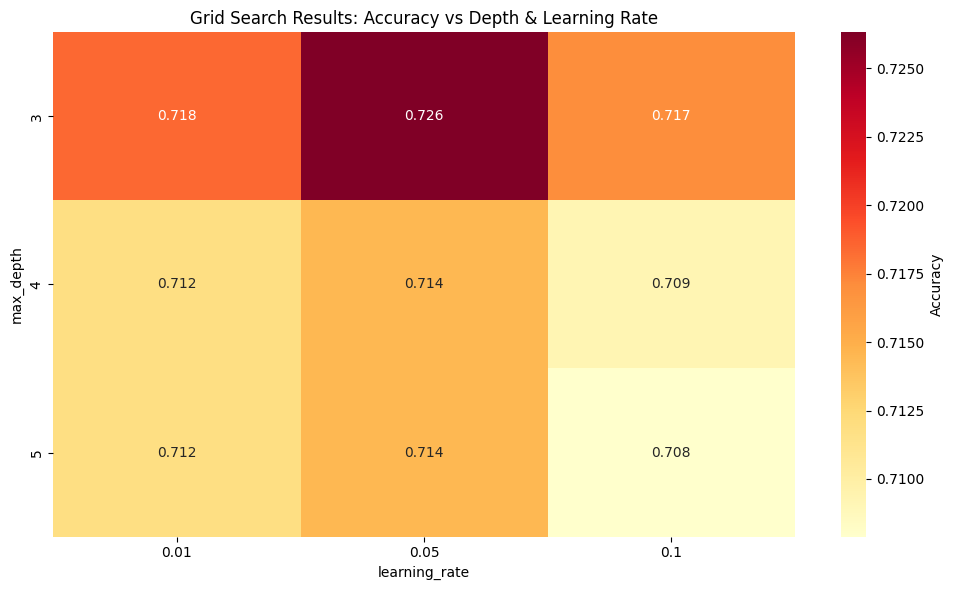

In [59]:
# Heatmap des résultats
grid_df = pd.DataFrame(results_grid)
pivot_table = grid_df.pivot_table(
    values='accuracy', 
    index='max_depth', 
    columns='learning_rate'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Accuracy'})
plt.title('Grid Search Results: Accuracy vs Depth & Learning Rate')
plt.tight_layout()
plt.show()

# TEST DES AUTRES PARAMÈTRES AVEC MEILLEURS LR ET DEPTH

In [60]:
best_overall_idx = np.argmax([r['accuracy'] for r in results_grid])
best_params = results_grid[best_overall_idx]

best_lr = best_params['learning_rate']
best_depth = best_params['max_depth']
print(" MEILLEURS PARAMÈTRES TROUVÉS :"
      )
print(f"Learning Rate: {best_lr}")
print(f"Max Depth: {best_depth}")


 MEILLEURS PARAMÈTRES TROUVÉS :
Learning Rate: 0.05
Max Depth: 3


In [61]:
print("=== OPTIMISATION DES AUTRES HYPERPARAMÈTRES ===")

# Paramètres à tester
subsample_values = [0.6, 0.7, 0.8, 0.9]
colsample_values = [0.6, 0.7, 0.8, 0.9]
min_child_weight_values = [1, 3, 5]
gamma_values = [0, 0.1, 0.2]

results_other_params = []

# Test 1: Subsample & Colsample_bytree
print(" Test Subsample & Colsample_bytree...")
for subsample in subsample_values:
    for colsample in colsample_values:
        params = {
            "objective": "multi:softprob",
            "num_class": 3,
            "eval_metric": "merror",
            "learning_rate": best_lr,
            "max_depth": best_depth,
            "subsample": subsample,
            "colsample_bytree": colsample,
            "min_child_weight": 1,  
            "gamma": 0,
            "seed": 42
        }
        
        bst = xgb.train(
            params, 
            dtrain, 
            num_boost_round=150,
            early_stopping_rounds=15,
            evals=[(dtest, 'eval')],
            verbose_eval=False
        )
        
        y_pred = bst.predict(dtest).argmax(axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        
        results_other_params.append({
            'param_group': 'subsample_colsample',
            'subsample': subsample,
            'colsample_bytree': colsample,
            'min_child_weight': 1,
            'gamma': 0,
            'accuracy': accuracy
        })

# Trouver meilleurs subsample/colsample
best_sub_col = max([r for r in results_other_params if r['param_group'] == 'subsample_colsample'], 
                   key=lambda x: x['accuracy'])
best_subsample = best_sub_col['subsample']
best_colsample = best_sub_col['colsample_bytree']

print(f"✅ Meilleurs: subsample={best_subsample}, colsample={best_colsample}, accuracy={best_sub_col['accuracy']:.4f}")

# %%
# Test 2: Min Child Weight
print(" Test Min Child Weight...")
for min_child in min_child_weight_values:
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "merror",
        "learning_rate": best_lr,
        "max_depth": best_depth,
        "subsample": best_subsample,      # Utilise les meilleurs trouvés
        "colsample_bytree": best_colsample,
        "min_child_weight": min_child,
        "gamma": 0,
        "seed": 42
    }
    
    bst = xgb.train(
        params, 
        dtrain, 
        num_boost_round=150,
        early_stopping_rounds=15,
        evals=[(dtest, 'eval')],
        verbose_eval=False
    )
    
    y_pred = bst.predict(dtest).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results_other_params.append({
        'param_group': 'min_child_weight',
        'subsample': best_subsample,
        'colsample_bytree': best_colsample,
        'min_child_weight': min_child,
        'gamma': 0,
        'accuracy': accuracy
    })

best_min_child = max([r for r in results_other_params if r['param_group'] == 'min_child_weight'], 
                     key=lambda x: x['accuracy'])['min_child_weight']
print(f" Meilleur min_child_weight: {best_min_child}")

# Test 3: Gamma
print("📊 Test Gamma...")
for gamma in gamma_values:
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "merror",
        "learning_rate": best_lr,
        "max_depth": best_depth,
        "subsample": best_subsample,
        "colsample_bytree": best_colsample,
        "min_child_weight": best_min_child,  # Utilise le meilleur trouvé
        "gamma": gamma,
        "seed": 42
    }
    
    bst = xgb.train(
        params, 
        dtrain, 
        num_boost_round=150,
        early_stopping_rounds=15,
        evals=[(dtest, 'eval')],
        verbose_eval=False
    )
    
    y_pred = bst.predict(dtest).argmax(axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    results_other_params.append({
        'param_group': 'gamma',
        'subsample': best_subsample,
        'colsample_bytree': best_colsample,
        'min_child_weight': best_min_child,
        'gamma': gamma,
        'accuracy': accuracy
    })

best_gamma = max([r for r in results_other_params if r['param_group'] == 'gamma'], 
                 key=lambda x: x['accuracy'])['gamma']
print(f" Meilleur gamma: {best_gamma}")


=== OPTIMISATION DES AUTRES HYPERPARAMÈTRES ===
 Test Subsample & Colsample_bytree...
✅ Meilleurs: subsample=0.8, colsample=0.8, accuracy=0.7224
 Test Min Child Weight...
 Meilleur min_child_weight: 1
📊 Test Gamma...
 Meilleur gamma: 0


In [62]:
# RÉCAPITULATIF FINAL
print("\ CONFIGURATION OPTIMALE COMPLÈTE:")
print(f"   Learning Rate: {best_lr}")
print(f"   Max Depth: {best_depth}")
print(f"   Subsample: {best_subsample}")
print(f"   Colsample_bytree: {best_colsample}")
print(f"   Min Child Weight: {best_min_child}")
print(f"   Gamma: {best_gamma}")

# Performance finale avec tous les meilleurs paramètres
final_params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "merror",
    "learning_rate": best_lr,
    "max_depth": best_depth,
    "subsample": best_subsample,
    "colsample_bytree": best_colsample,
    "min_child_weight": best_min_child,
    "gamma": best_gamma,
    "seed": 42
}

final_bst = xgb.train(final_params, dtrain, num_boost_round=200,
                     early_stopping_rounds=20, evals=[(dtest, 'eval')])

y_pred_final = final_bst.predict(dtest).argmax(axis=1)
final_accuracy = accuracy_score(y_test, y_pred_final)

print(f" ACCURACY FINALE: {final_accuracy:}")

\ CONFIGURATION OPTIMALE COMPLÈTE:
   Learning Rate: 0.05
   Max Depth: 3
   Subsample: 0.8
   Colsample_bytree: 0.8
   Min Child Weight: 1
   Gamma: 0
[0]	eval-merror:0.31579
[1]	eval-merror:0.30263
[2]	eval-merror:0.28947
[3]	eval-merror:0.28026
[4]	eval-merror:0.28553
[5]	eval-merror:0.28421
[6]	eval-merror:0.28421
[7]	eval-merror:0.28421
[8]	eval-merror:0.27105
[9]	eval-merror:0.26711
[10]	eval-merror:0.26711
[11]	eval-merror:0.27105
[12]	eval-merror:0.27105
[13]	eval-merror:0.27105
[14]	eval-merror:0.27632
[15]	eval-merror:0.28026
[16]	eval-merror:0.28026
[17]	eval-merror:0.28421
[18]	eval-merror:0.27632
[19]	eval-merror:0.26842
[20]	eval-merror:0.27632
[21]	eval-merror:0.27500
[22]	eval-merror:0.27632
[23]	eval-merror:0.27500
[24]	eval-merror:0.27763
[25]	eval-merror:0.28026
[26]	eval-merror:0.27763
[27]	eval-merror:0.27763
[28]	eval-merror:0.27368
 ACCURACY FINALE: 0.7263157894736842


<>:2: SyntaxWarning: invalid escape sequence '\ '
<>:2: SyntaxWarning: invalid escape sequence '\ '
C:\Users\User\AppData\Local\Temp\ipykernel_2900\714671514.py:2: SyntaxWarning: invalid escape sequence '\ '
  print("\ CONFIGURATION OPTIMALE COMPLÈTE:")


RE ENTRAINEMENT AVEC PARAMETRE OPTIMAL SUR LES 4 PREMIERES SAISONS (AU LIEU DE 3)

In [63]:
# Entraînement sur saisons 2-5, test sur saison 6
train_mask = df['season_id'].isin([2, 3, 4, 5])  # Une saison de plus !
test_mask = df['season_id'] == 6                 # Saison test

X_train_final = X[train_mask]
X_test_final = X[test_mask]
y_train_final = y_encoded[train_mask] 
y_test_final = y_encoded[test_mask]

# Réentraîner avec tous les meilleurs paramètres
final_params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "merror",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1, 
    "gamma": 0,
    "seed": 42
}

dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final)
dtest_final = xgb.DMatrix(X_test_final, label=y_test_final)

final_bst = xgb.train(final_params, dtrain_final, num_boost_round=150,
                     early_stopping_rounds=20, evals=[(dtest_final, 'eval')],
                     verbose_eval=False)

# Performance finale
y_pred_final = final_bst.predict(dtest_final).argmax(axis=1)
final_accuracy = accuracy_score(y_test_final, y_pred_final)
print(f" Performance sur saison 6 (futur): {final_accuracy:.4f}")

 Performance sur saison 6 (futur): 0.6684


# Entrainement final avec toutes les saisons disponibles

In [ ]:
import os
import joblib
from datetime import datetime
from collections import Counter

print("=== ENTRAÎNEMENT FINAL AVEC TOUTES LES DONNÉES ===")

# Créer dossier dédié
dossier_modele = 'modele_simulation_saison_complete'
os.makedirs(dossier_modele, exist_ok=True)


# Utiliser TOUTES les saisons pour l'entraînement final
X_final = X  # Toutes les données
y_final = y_encoded  # Toutes les données encodées

# Gestion du déséquilibre sur toutes les données
class_counts = Counter(y_final)
total = sum(class_counts.values())
weights = {cls: total/count for cls, count in class_counts.items()}
sample_weights = [weights[label] for label in y_final]

dtrain_final = xgb.DMatrix(X_final, label=y_final, weight=sample_weights)

# Paramètres finaux (ceux que vous avez déjà identifiés)
final_params = {
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "merror",
    "learning_rate": best_lr,
    "max_depth": best_depth,
    "subsample": best_subsample,
    "colsample_bytree": best_colsample,
    "min_child_weight": best_min_child,
    "gamma": best_gamma,
    "seed": 42
}

# Entraînement final
modele_final = xgb.train(
    final_params, 
    dtrain_final, 
    num_boost_round=200,
    verbose_eval=False
)
print("✅ Modèle final entraîné avec toutes les données")

In [ ]:
# 4. SAUVEGARDER LE MODÈLE FINAL
modele_final.save_model(f'{dossier_modele}/modele_xgboost_simulation.json')
print("Modèle XGBoost final sauvegarde")

# 5. SAUVEGARDER MÉTADONNÉES COMPLÈTES
metadata = {
    'performance': {
        'accuracy_test_reference': float(final_accuracy),
        'saisons_utilisees': 'toutes',
        'nombre_observations': len(X_final)
    },
    'hyperparametres': {
        'learning_rate': best_lr,
        'max_depth': best_depth,
        'subsample': best_subsample,
        'colsample_bytree': best_colsample,
        'min_child_weight': best_min_child,
        'gamma': best_gamma
    },
    'preprocessing': {
        'label_encoder': le,
        'feature_names': list(X.columns),
        'nombre_features': X.shape[1]
    },
    'strategie': {
        'usage': 'simulation_saison_complete_avant_debut',
        'entrainement': 'toutes_donnees_disponibles',
        'avantage': 'ne_requiert_pas_forme_recente'
    },
    'entrainement': {
        'date': datetime.now().isoformat(),
        'version': '1.0_final'
    }
}

joblib.dump(metadata, f'{dossier_modele}/metadata.pkl')
print("Metadonnees sauvegardees")

# 6. 
with open(f'{dossier_modele}/RESUME_MODELE_FINAL.txt', 'w', encoding='utf-8') as f:
    f.write(f"""
=== MODELE FINAL - SIMULATION SAISON COMPLETE ===
Date: {datetime.now().strftime("%Y-%m-%d %H:%M")}

PERFORMANCE & PARAMETRES
- Accuracy reference (test): {final_accuracy:.4f}
- Learning Rate optimal: {best_lr}
- Max Depth optimal: {best_depth}
- Subsample: {best_subsample}
- Colsample_bytree: {best_colsample}
- Min Child Weight: {best_min_child}
- Gamma: {best_gamma}

DONNEES D'ENTRAINEMENT
- Saisons utilisees: TOUTES disponibles
- Nombre d'observations: {len(X_final)}
- Nombre de features: {X.shape[1]}

STRATEGIE
- Usage: Simulation saison complete avant debut
- Entrainement: Modele final avec toutes les donnees
- Compatible Monte Carlo: OUI
""")

print("SAUVEGARDE TERMINEE!")
print("Dossier cree: 'modele_simulation_saison_complete/'")
print("Modele final PRET pour les simulations Monte Carlo!")